## 데이터 불러오기

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df1 = pd.read_csv('client.csv', encoding='cp949')
df2 = pd.read_csv('campaign_etc.csv', encoding='cp949')
df = pd.merge(df1, df2, on='index', how='inner')
df.drop(['index', 'poutcome'], axis='columns', inplace=True)
df.insert(5, 'housing', '')
df.loc[:25131, 'housing'] = 'yes'
df.loc[25131:, 'housing'] = 'No'
df.rename(columns={'y':'deposit'},inplace=True)
df.replace({'yes': 1, 'yes': 1, 'No': 0, 'no':0},inplace=True)
df

,age,job,marital,education,default,housing,balance,loan,contact,day,month,duration,campaign,pdays,pdays_d,previous,deposit
0,58.0,management,married,tertiary,0,1,2143.0,0,unknown,5,may,261.0,1,-1,-1,0,0
1,34.0,technician,single,tertiary,0,1,2047.0,0,cellular,28,jul,57.0,5,-1,-1,0,0
2,39.0,management,single,tertiary,0,1,26.0,0,cellular,28,jul,110.0,18,-1,-1,0,0
3,40.0,management,married,tertiary,0,1,0.0,0,cellular,28,jul,52.0,11,-1,-1,0,0
4,37.0,technician,single,secondary,0,1,1127.0,0,cellular,20,apr,249.0,2,-1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,43.0,management,married,tertiary,0,0,1.0,0,cellular,22,aug,239.0,4,-1,-1,0,0
45207,58.0,retired,married,primary,0,0,701.0,0,cellular,22,aug,137.0,4,-1,-1,0,0
45208,52.0,technician,married,secondary,0,0,2944.0,0,cellular,22,aug,22.0,18,-1,-1,0,0
45209,46.0,entrepreneur,married,tertiary,0,0,1920.0,0,cellular,22,aug,604.0,6,-1,-1,0,1


# 결측치 처리

In [86]:
# age 결측치 (12개) 중앙값으로 채우기
age_median = df['age'].median(axis=0)  # age_median = 39
df['age'].fillna(age_median, inplace=True)
df.isnull().sum() # age 결측치 0개 된 것 확인 가능

# duration 결측치 (123개) 중앙값으로 채우기
duration_median = df['duration'].median(axis=0) # duration_median = 181
df['duration'].fillna(duration_median, inplace=True)
df.isnull().sum() # duration 결측치 0개 된 것 확인 가능

# balance 결측치 (16개) 제거 
## 남은 결측치가 balance 결측치뿐이라 전체에 대해 dropna 실행가능
df.dropna(inplace=True)
df.isnull().sum() # 모든 결측치 사라짐

age          0
job          0
marital      0
education    0
default      0
housing      0
balance      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
pdays_d      0
previous     0
deposit      0
dtype: int64

# 이상치 처리  

이상치에는 두가지가 존재. 한 가지는 아예 말이 안되는 잘못된 값이 있을 수 있고, 이는 제거하거나, 올바른 값으로 대체가 가능할 때는 수정 해주어야 할 값임. 두 번째는 불가능한 값은 아니기는 한데 분석에 영향을 미칠만큼 분포에서 벗어난 이상한 값. 이런 값을 실제 데이터가 이런 거라서 이걸 임의로 다른 값으로 변경하게 되면 결과에 오히려 영향을 줄 수 있다고 봄. 분석에 방해가 될 정도로 이상한 값이라면 제거하는 것이 좋다고 생각.  

column 각각에 대하여 오류값, 이상값을 구분하여 살펴보고 각각에 기준 적용하여 이상치 처리함.
 
1. age: 최솟값, 최댓값이 모두 충분히 가능한 값으로 오류값은 존재하지 않음. 이상값으로 분석에 악영향을 줄만큼 분포에서 벗어난 값은 없다고 판단. 워낙 값의 범위가 크지 않아 특별히 제외시켜야 할 값 없다고 판단하여 이상치 처리 별도로 하지 않음.

2. balance: 잔고를 의미하므로 음수는 오류값으로 생각하고 제거. 그 후에 IQR 기준으로 자르려고 했으나 보편적인 기준인 25%-1.5IQR 이하, 75%+1.5IQR 이상 으로 적용하기에는 outlier 로 잡히는 값이 지나치게 많고 범주도 너무 넓음. 그리고 boxplot 상으로 보았을 때 이 outlier 들이 꽤나 촘촘하게 분포하고 있어 이를 모두 제거하는 것은 적합하지 않다고 판단. boxplot 상에서 시각적으로 판단해서 50000이상의 값을 제거하기로 결정. 

3. day: 이전달 마지막 contact한 날짜라서 1-31 범주 벗어나면 잘못된 값이므로 제거필요. 하지만 코드 실행시켜서 확인한 결과 모두 1-31 범주 내에 들어와서 제거할 데이터 없었음.

4. duration : contact 이어진 시간을 sec 단위로 표시한 데이터인데 sec 단위라서 범주가 매우매우 넓음. 25%-1.5IQR 이하, 75%+1.5IQR 이상을 outlier 로 설정하여 제거

5. campaign: contact 횟수 의미하며, 오류값으로 보이는 값 없음. 값의 분포가 age 처럼 넓지 않은 편이라 특별히 이상치로 처리할 데이터 없다고 판단. 별도의 이상치 처리 하지 않음. 

6. pdays: 이전 contact으로부터 지난 날을 의미하는 값으로 음수값을 띨 수 없으므로 음수값은 오류값으로 생각하고 제거. 나머지 값들의 분포를 보았을 때에는, IQR 로 자르기에는 꽤 많은 수가 제거되는데 그렇게 값의 범주가 크지도 않고 분석에 큰 영향을 주지 않을 것 같다고 판단하여 이보다 적은 숫자만을 제거하고자 boxplot 상에서 시각적으로 기준점을 설정함. 700 이상에 해당하는 값을 제거하기로 결정.  

7. previous : 이전 contact 횟수를 의미하여 불가능한 값이랄 건 없지만, boxplot 상으로 보았을 때 한 개의 데이터가 혼자 300에 가까운 값을 보여 분석에 방해가 될 것이라 판단하여 제거. 나머지 데이터 중에서는 boxplot 상에서 분포가 조금 띄엄띄엄 있는 것으로 나타나는 30 이상의 data를 제거.

In [87]:
# age 는 자를 것 없음. 그대로 유지 (범위 자체가 크지 않고 최댓값이 95세로 오류값이라고 보기 어려우므로)


# balance 이상치 처리
# 음수값 제거
balance_negative = df['balance'] < 0
df.drop(df.loc[balance_negative].index, axis='index', inplace=True)

# IQR 기준 이상치 제거 -> 너무 많이 잘려나가서 기각
#q1, q3 = df['balance'].quantile(0.25), df['balance'].quantile(0.75)
#iqr = q3-q1
#condition = (df['balance'] > q1-1.5*iqr) & (df['balance'] < q3+1.5 *iqr)
#df['balance'][condition].describe()

# 50000 이상인 값 제거 : boxplot 상으로 시각적으로 판단
balance_outlier = df['balance'] > 50000
df.drop(df.loc[balance_outlier].index, axis='index', inplace=True)


# day 이상치 처리
day_outlier = (df['day']<0) | (df['day']>31)
df.drop(df.loc[day_outlier].index, axis='index', inplace=True)


#campaign 는 유지 (25%-1.5IQR, 75%+1.5IQR 기준으로 outlier 확인 했을 때에 3234개가 outlier로 잡히고, 41949개가 남음.상대적으로 outlier 비율 적다고 생각하여 유지)


#duration 이상치 처리
# IQR 기준 이상치 제거
duration_q1, duration_q3 = df['duration'].quantile(0.25), df['duration'].quantile(0.75)
duration_iqr = duration_q3-duration_q1
condition = (df['duration'] > duration_q1-1.5*duration_iqr) & (df['duration'] < duration_q3+1.5 *duration_iqr)
df['duration'][condition].describe()


# pdays 이상치 처리
# 음수값 제거
pdays_negative = df['pdays'] <0
df.drop(df.loc[pdays_negative].index, axis='index', inplace=True)
# 700 이상 제거 : boxplot 상에서 시각적으로 판단
pdays_outlier = df['pdays'] > 700
df.drop(df.loc[pdays_outlier].index, axis='index', inplace=True)


# previous 이상치 처리
# 혼자 동떨어져있는 250 이상 값 제거하기 : 혼자 너무 동떨어져있는데 boxplot 상에서 확인되어서 먼저 제거
previous_outlier = df['previous'] > 250
df.drop(df.loc[previous_outlier].index, axis='index', inplace=True)

# 30 이상 제거: boxplot 상으로 시각적으로 판단
previous_outlier2 = df['previous'] > 30
df.drop(df.loc[previous_outlier2].index, axis='index', inplace=True)

df.describe()

,age,default,housing,balance,loan,day,duration,campaign,pdays,pdays_d,previous,deposit
count,7718.000000,7718.000000,7718.000000,7718.000000,7718.000000,7718.000000,7718.000000,7718.000000,7718.000000,7718.000000,7718.000000,7718.00000
mean,41.043794,0.002850,0.607930,1649.260301,0.125551,14.335579,261.246437,2.044960,218.666235,218.666235,3.090568,0.23944
std,11.551706,0.053317,0.488244,2791.903196,0.331364,7.957976,235.842310,1.546958,109.771390,109.771390,3.108793,0.42677
min,19.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.00000
25%,33.000000,0.000000,0.000000,230.000000,0.000000,7.000000,113.000000,1.000000,126.000000,126.000000,1.000000,0.00000
50%,38.000000,0.000000,1.000000,680.000000,0.000000,14.000000,195.000000,2.000000,189.000000,189.000000,2.000000,0.00000
75%,48.000000,0.000000,1.000000,1856.500000,0.000000,20.000000,324.000000,2.000000,321.000000,321.000000,4.000000,0.00000
max,93.000000,1.000000,1.000000,37378.000000,1.000000,31.000000,2219.000000,16.000000,690.000000,690.000000,30.000000,1.00000


# 중복되는 column 제거 (유일성)

겹치는 row가 있을 경우에는 ```df.drop_duplicates(inplace=True)```로 가능할 텐데 이렇게 했을 때 겹치는 값 없었고, 겹치는 column 살펴 보기 위하여 ```df.T.duplicated()```로 확인했더니 'pdays_d' column이 'pdays'와 중복인 것을 확인하여 이를 제거하기로 함.

In [88]:
df = df.T.drop_duplicates().T
df= df.astype({'default':'int','loan':'int','day':'int','campaign':'int','pdays':'int','previous':'int','deposit':'int','housing':'int', 'age':'float', 'balance':'float','duration':'float'})

In [89]:
# 최종적으로 7718개의 데이터가 남았음. 이를 가지고 분석 진행하기로 함.

# 1. 고객층 특성 분석 : 포르투갈 은행의 고객층은 어떤 특징이 있을까?  
  
## 순서  

1.1. 전고객의 나이 분포  
1.1.1. 학력별 나이 분포  
1.1.2. 결혼상태별 나이분포  

1.2. 전고객의 잔고 분포(나이에 따라)  

1.3. 전고객의 결혼상태 분포  

1.4. 전고객의 직업군 분포

Text(0.5, 1.0, '고객층의 age 분포')

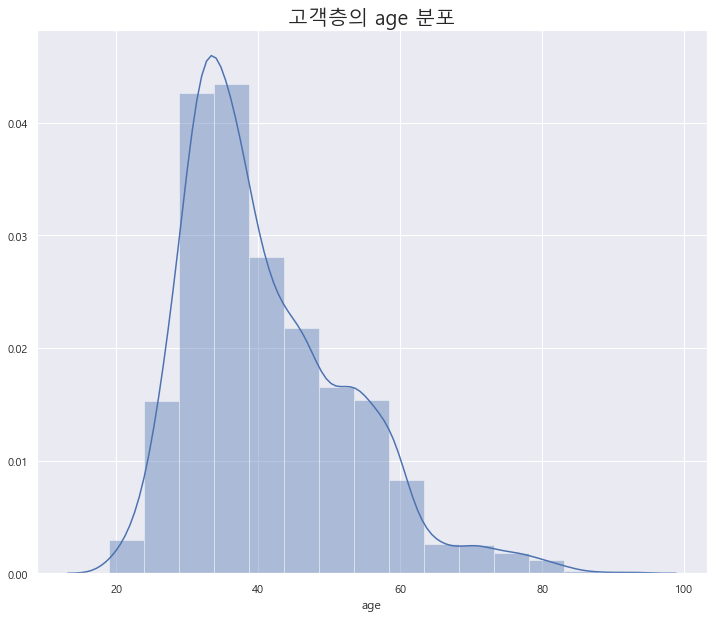

In [90]:
# 1.1 전고객의 나이 분포
age1 = plt.subplots(figsize=(12, 10))
plt.rcParams['font.family'] = 'Malgun Gothic'
age1 = sns.distplot(df['age'], bins=15)
age1.set_title("고객층의 age 분포", size=20)

Text(0.5, 1.0, '학력에 따른 나이 분포')

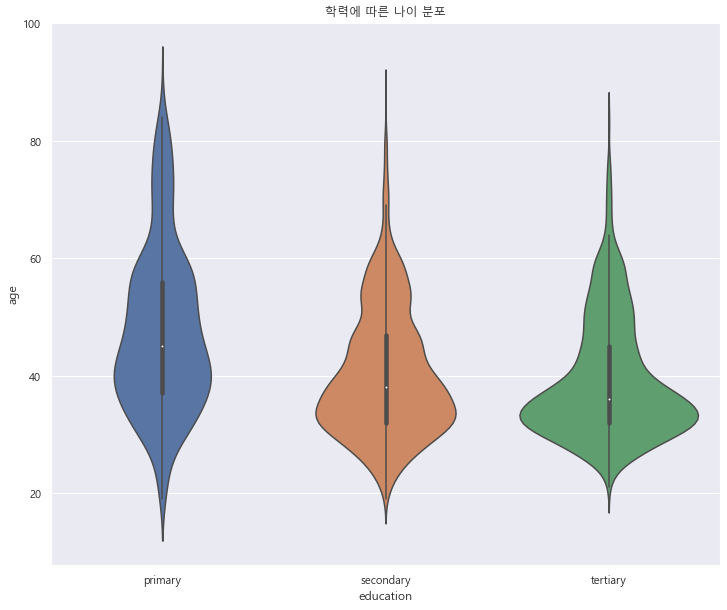

In [91]:
# 1.1.1. 학력별 나이 분포
education_age = sns.violinplot(data=df, x='education', y='age', order=['primary', 'secondary', 'tertiary'])
education_age.set_title("학력에 따른 나이 분포")

Text(0.5, 1.0, '결혼 상태에 따른 나이 분포')

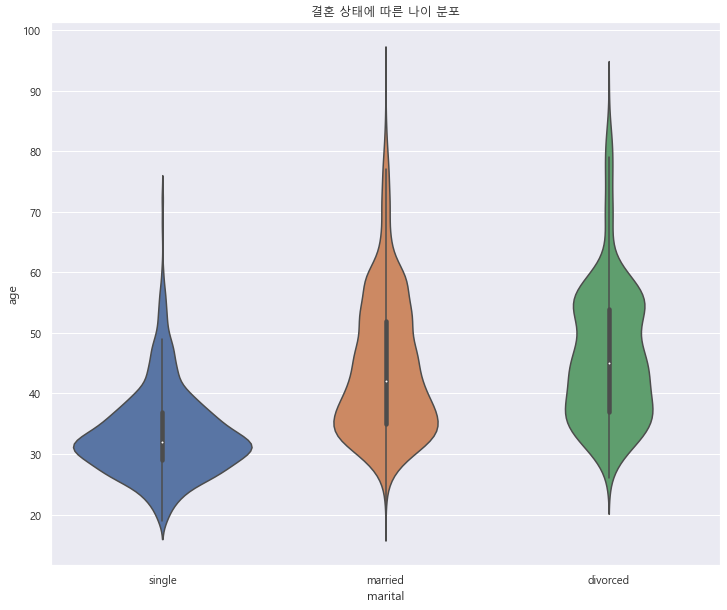

In [92]:
# 1.1.2. 결혼상태별 나이 분포
marital_age = sns.violinplot(data=df, x='marital', y='age', order=['single', 'married', 'divorced'])
marital_age.set_title("결혼 상태에 따른 나이 분포")

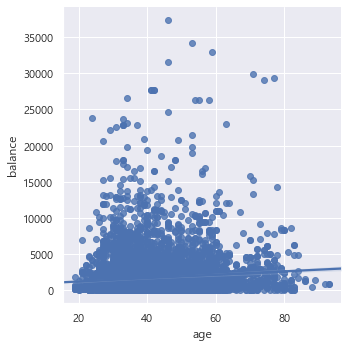

In [93]:
# 1.2. 전고객의 잔고 분포 
sns.lmplot(data = df, x = 'age', y ='balance')

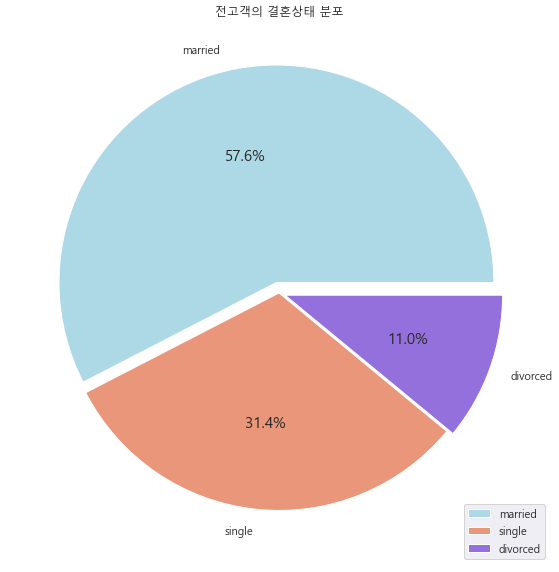

In [94]:
# 1.3. 전고객의 결혼상태 분포
marital = df['marital'].value_counts()
plt.figure(figsize=(12, 10))
plt.title("전고객의 결혼상태 분포")
plt.rcParams['font.size'] = 15
plt.pie(marital, labels=['married', 'single', 'divorced'], colors=['lightblue', 'darksalmon', 'mediumpurple']
        , autopct='%.1f%%', explode=(0.05, 0, 0.03))
plt.legend()
plt.show()

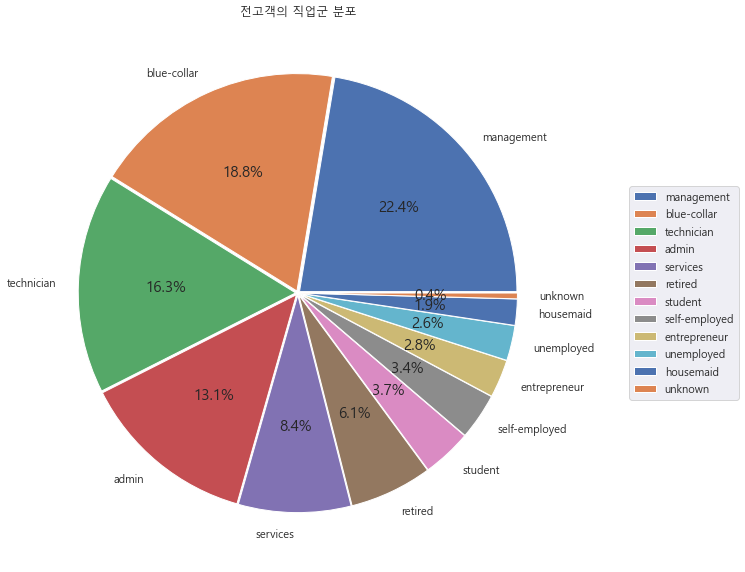

In [95]:
# 1.4. 전고객의 직업군 분포
job = df['job'].value_counts()
plt.figure(figsize=(12, 10))
plt.title("전고객의 직업군 분포")
plt.rcParams['font.size'] = 15
plt.pie(job, labels=['management', 'blue-collar', 'technician', 'admin', 'services', 'retired', 'student', 'self-employed', 'entrepreneur', 'unemployed', 'housemaid', 'unknown']
        , autopct='%.1f%%', explode=(0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01))
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.show()

# 2. 마케팅 전략 수립을 위한 지표 분석  
  
## 순서  

2.1. 마케팅 대상  
2.1.1. 직업군에 따른 deposit 성사비율  
: 직업별 마케팅 전략을 어떻게 달리 해야할까?  
2.1.2. 학력에 따른 deposit 성사비율  
-education에 따른 balance(mean) 분포  
2.1.3. 결혼 상태에 따른 deposit 성사 비율  
2.1.4. deposit 들은 사람들의 연령대 분포  
2.1.5. 이전 캠페인 동안 연락 횟수(campaign)에 따른 성사 비율  


2.2. 마케팅 시기  
2.2.1. pdays 분포: 마지막 contact 후 어느 정도 시간 지났을 해 홍보하는게 효과 좋을까?  
2.2.2. month에 따른 deposit 성사 비율: 어느 달에 가장 마케팅 성사율이 높을까?  


2.3. 마케팅 방법  
2.3.1. contact 수단 분석: 어떤 수단으로 마케팅 하는게 효과 좋을까?  
-'contact' :celluar, telephone, unknown 총 3카테고리  
-전체 contact 비율/ education, job과 contact 각각의 contingency table 확인 (고객의이용도)  
-contact에 따른 deposit 결과 contingency table 확인 (성공률)   
2.3.2. duration 분석: contact 지속 시간은 어느 정도로 잡고 홍보 전략을 짜야할까?  
-연령대에 따른 duration 분포 -> deposit Yes/No 나누어서 분포 비교

C:\Users\Home\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Home\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


AxesSubplot(0.125,0.125;0.62x0.755)
               age   default   housing   balance      loan       day  \
age       1.000000 -0.018297 -0.179175  0.096661 -0.006616  0.018988   
default  -0.018297  1.000000 -0.001864 -0.024961  0.023749  0.014848   
housing  -0.179175 -0.001864  1.000000 -0.092035  0.107261 -0.064219   
balance   0.096661 -0.024961 -0.092035  1.000000 -0.076212  0.055418   
loan     -0.006616  0.023749  0.107261 -0.076212  1.000000  0.008886   
day       0.018988  0.014848 -0.064219  0.055418  0.008886  1.000000   
duration  0.057766  0.001614 -0.075744  0.034417 -0.042525 -0.012453   
campaign  0.001318  0.000017  0.059199  0.000292  0.007946 -0.028425   
pdays    -0.104720  0.013447  0.347401 -0.104235  0.017818 -0.094255   
previous  0.012288  0.014078 -0.004691  0.012657  0.018522 -0.009976   
deposit   0.073075 -0.018609 -0.321805  0.055593 -0.119139  0.031663   

          duration  campaign     pdays  previous   deposit  
age       0.057766  0.001318 -0.104720

C:\Users\Home\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Home\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


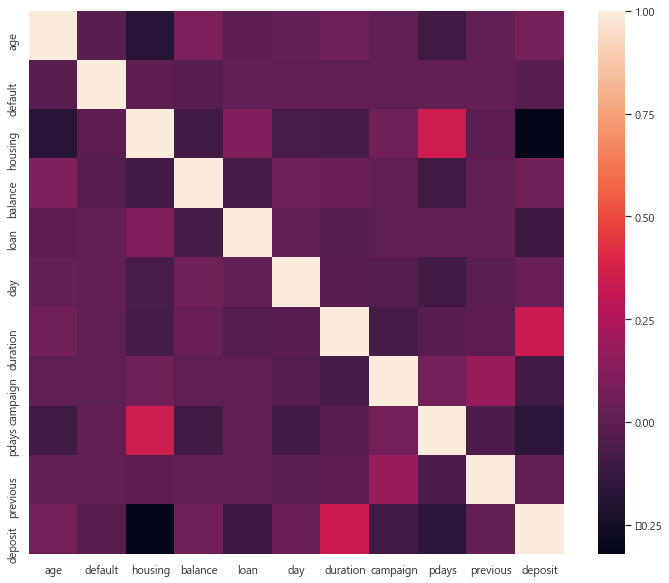

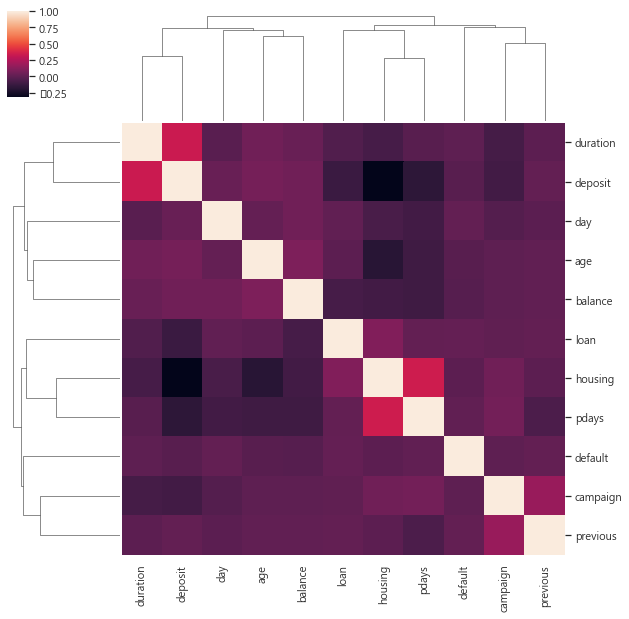

In [96]:
# 전체 요소간의 상관관계 분석

print(sns.heatmap(df.corr()))
print(df.corr())

corr = df.corr()
print(sns.clustermap(corr))

               age   default   housing      balance      loan        day  \
deposit                                                                    
0        40.570187  0.003407  0.696082  1562.179046  0.147700  14.194208   
1        42.548160  0.001082  0.327922  1925.865801  0.055195  14.784632   

           duration  campaign       pdays  previous  
deposit                                              
0        216.500000  2.126917  228.873254  3.058433  
1        403.379329  1.784632  186.244589  3.192641  


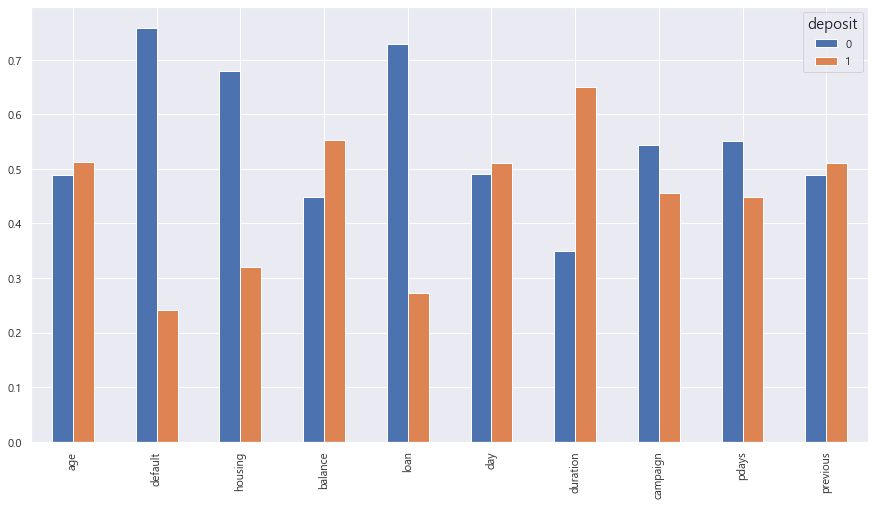

In [97]:
# groupby("deposit")을 이용해 수치적, 시각적으로 파악

deposit = df.groupby('deposit').mean()
print(deposit)

for i in list(deposit.columns):
    deposit.loc[0,i] = deposit.loc[0,i]/deposit[i].sum()
    deposit.loc[1,i] = 1 - deposit.loc[0,i]
    deposit.loc['sub',i] = deposit.loc[0,i] - deposit.loc[1,i]
deposit.loc[[0,1]].T.plot(kind='bar',stacked = False)
deposit
fig = plt.gcf(); fig.set_size_inches(15,8)

Text(0.5, 1.0, '직업군에 따른 적금 개설 성사 비율')

<Figure size 864x720 with 0 Axes>

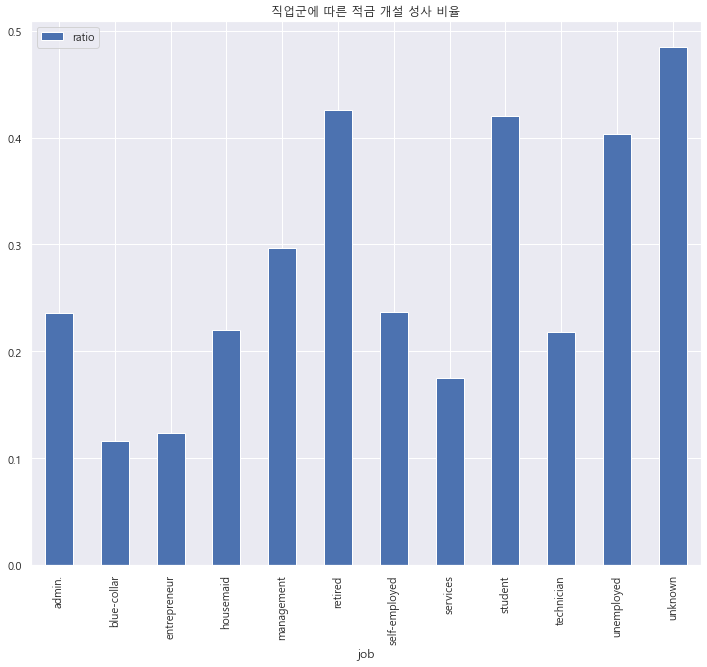

In [98]:
# 2.1. 마케팅 대상  
## 2.1.1. 직업군에 따른 deposit 성사비율 : 직업별 마케팅 전략을 어떻게 달리 해야할까?
deposit_true = df['deposit'] == 1
deposit_false = df['deposit'] == 0
true = df.loc[deposit_true]
true_job_groups = true.groupby("job")
true_series = true_job_groups['deposit'].count()  # 모든 column에서 데이터 수는 동일하기는 한데 굳이 dataframe으로 같은 값 여러개 띄울 필요 없어서 한 column 지정해서 호출한 것
false = df.loc[deposit_false]
false_job_groups = false.groupby("job")
false_series = false_job_groups['deposit'].count()

df_concat = pd.concat([true_series, false_series], axis=1)
df_concat.columns = ['true', 'false']
df_concat['ratio'] = df_concat['true']/(df_concat['true']+df_concat['false'])

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(12, 10))
job_concat = df_concat.plot(kind='bar', y='ratio')
job_concat.set_title("직업군에 따른 적금 개설 성사 비율")

In [99]:
### 직업군에 따른 마케팅 전략 도출을 위한 직업군별 분석
print(df.groupby('job').mean())

# deposit=yes 한 데이터를 직업별로 나눠봄
deposit_yes=df['deposit']==1
deposit_yes1=df[deposit_yes]
deposit_by=deposit_yes1.groupby('job')
yes=deposit_by.mean()
print(yes)

print(deposit_yes1.describe())
print(deposit_yes1.mean())

                     age   default   housing      balance      loan  \
job                                                                   
admin.         39.288955  0.003945  0.648915  1273.357988  0.150888   
blue-collar    39.557241  0.003448  0.826897  1295.446207  0.141379   
entrepreneur   42.371560  0.004587  0.706422  1287.009174  0.233945   
housemaid      48.360000  0.006667  0.413333  1733.000000  0.086667   
management     40.262153  0.003472  0.546875  2108.166667  0.101852   
retired        66.056962  0.000000  0.141350  2446.620253  0.063291   
self-employed  39.537594  0.003759  0.582707  1966.154135  0.109023   
services       38.454264  0.000000  0.761240  1313.234109  0.148837   
student        26.833922  0.000000  0.201413  1549.526502  0.014134   
technician     39.445064  0.003185  0.646497  1617.043790  0.156847   
unemployed     40.552239  0.000000  0.432836  1621.611940  0.069652   
unknown        48.363636  0.000000  0.151515  1538.818182  0.030303   

     

In [100]:
### 직업 별로 deposit no한 데이터 분석
deposit_no=df['deposit']==0
deposit_no1=df[deposit_no]
deposit_by_no=deposit_no1.groupby('job')
no=deposit_by_no.mean()
print(no)

print(deposit_no1.describe())

                     age   default   housing      balance      loan  \
job                                                                   
admin.         39.028387  0.005161  0.712258  1187.225806  0.175484   
blue-collar    39.570203  0.003900  0.862715  1286.988300  0.149766   
entrepreneur   42.235602  0.005236  0.748691  1221.544503  0.261780   
housemaid      47.880342  0.008547  0.470085  1915.786325  0.111111   
management     40.150617  0.003292  0.641975  2022.747325  0.124280   
retired        64.378676  0.000000  0.187500  2384.033088  0.080882   
self-employed  39.655172  0.004926  0.660099  1881.197044  0.113300   
services       38.370301  0.000000  0.823308  1304.979323  0.161654   
student        27.146341  0.000000  0.298780  1476.359756  0.024390   
technician     39.272912  0.004073  0.714868  1506.450102  0.181263   
unemployed     40.166667  0.000000  0.600000  1700.891667  0.100000   
unknown        53.352941  0.000000  0.235294  2042.294118  0.000000   

     

In [101]:
### deposit yes - no 한 값의 평균 값 보며 수치로 단순하게 변수들과 deposit간의 관계를 나타내봄 (직업무관)
print(deposit_yes1.mean()-deposit_no1.mean())

# 직업 별로 yes와 no 의 차이 분석
comparison=yes-no
print(comparison)
print(comparison.corr())

age           1.977973
default      -0.002325
housing      -0.368160
balance     363.686755
loan         -0.092505
day           0.590424
duration    186.879329
campaign     -0.342284
pdays       -42.628665
previous      0.134208
deposit       1.000000
dtype: float64
                     age   default   housing      balance      loan       day  \
job                                                                             
admin.          1.105504 -0.005161 -0.268743   365.431097 -0.104354  0.488838   
blue-collar    -0.111869 -0.003900 -0.309143    72.999796 -0.072385  0.982876   
entrepreneur    1.097731 -0.005236 -0.341284   528.566608 -0.224743 -3.662595   
housemaid       2.180264 -0.008547 -0.257964  -830.846931 -0.111111  1.630148   
management      0.375699  0.000606 -0.320338   287.728308 -0.075547  0.159281   
retired         3.938155  0.000000 -0.108292   146.862951 -0.041278  0.893492   
self-employed  -0.496442 -0.004926 -0.326765   358.707718 -0.018062  0.123153   
ser

In [102]:
### 평균보다 낮고 높은 (deposit) 직업 군 분석 
job_by=df.groupby('job')
print(job_by['deposit'].mean().sort_values())

# 직업별로 자세하게 들어가기 위해 전체 직업의 평균 다시 불러오기 
job_by_mean=job_by.mean()
print(job_by_mean)

job
blue-collar      0.115862
entrepreneur     0.123853
services         0.175194
technician       0.218153
housemaid        0.220000
admin.           0.235700
self-employed    0.236842
management       0.296875
unemployed       0.402985
student          0.420495
retired          0.426160
unknown          0.484848
Name: deposit, dtype: float64
                     age   default   housing      balance      loan  \
job                                                                   
admin.         39.288955  0.003945  0.648915  1273.357988  0.150888   
blue-collar    39.557241  0.003448  0.826897  1295.446207  0.141379   
entrepreneur   42.371560  0.004587  0.706422  1287.009174  0.233945   
housemaid      48.360000  0.006667  0.413333  1733.000000  0.086667   
management     40.262153  0.003472  0.546875  2108.166667  0.101852   
retired        66.056962  0.000000  0.141350  2446.620253  0.063291   
self-employed  39.537594  0.003759  0.582707  1966.154135  0.109023   
services       

In [103]:
## 각 직업군 별 변수의 상대적 영향력 측정 (--> 다른 패턴 보이는 직업군도 찾을 수 있음)
## :(yes-no 평균) / 그 변수의 원래 평균 * 100 

## 한 직업군 안에서 더 영향 미치는 변수 측정 

relative_comparison=comparison/job_by_mean *100
print(relative_comparison)

                     age     default     housing    balance        loan  \
job                                                                       
admin.          2.813778 -130.838710  -41.414260  28.698222  -69.160211   
blue-collar    -0.282804 -113.104524  -37.385944   5.635108  -51.199173   
entrepreneur    2.590727 -114.136126  -48.311588  41.069374  -96.066645   
housemaid       4.508404 -128.205128  -62.410708 -47.942697 -128.205128   
management      0.933131   17.465887  -58.576070  13.648271  -74.173312   
retired         5.961756         NaN  -76.612605   6.002687  -65.219860   
self-employed  -1.255621 -131.034483  -56.077123  18.244130  -16.567578   
services        1.246303         NaN  -46.540063   3.587938  -49.153408   
student        -2.768809         NaN -114.964330  11.229339 -172.560976   
technician      2.000583 -127.902240  -48.477851  31.350728  -71.355887   
unemployed      2.359401         NaN  -95.836526 -12.131828 -108.121693   
unknown       -21.277228 

education
primary      1555.922996
secondary    1396.358563
tertiary     2053.100000
unknown      1829.382353
Name: balance, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


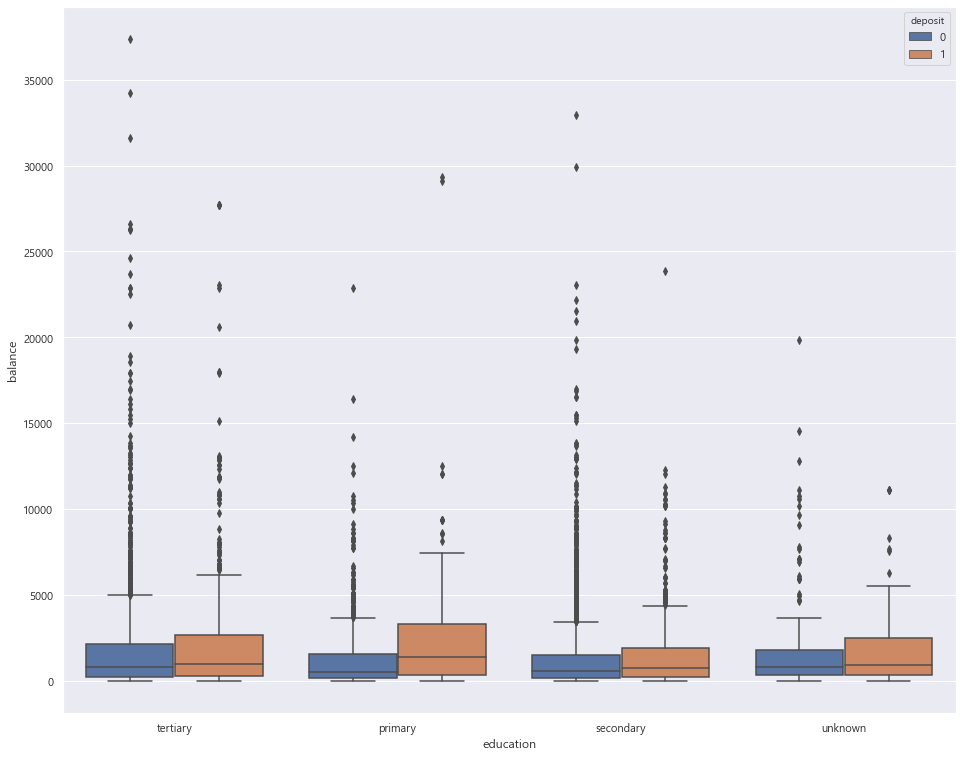

In [104]:
# 2.1. 마케팅 대상
## 2.1.2. 학력에 따른 deposit 성사비율 : education에 따른 balance(mean) 분포

edu = df.groupby('education').mean()
print(edu['balance'])

plt.subplots(figsize=(16, 13))
print(sns.boxplot(data=df, x='education', y='balance' ,hue='deposit'))

Text(0.5, 1.0, '결혼 상태에 따른 적금 개설 성사 비율')

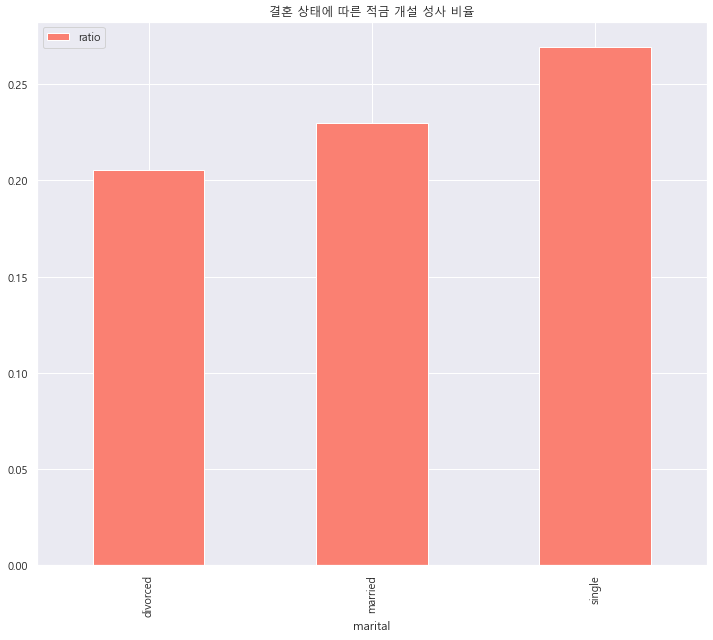

In [105]:
# 2.1. 마케팅 대상
## 2.1.3. 결혼 상태에 따른 deposit 성사 비율

deposit_true = df['deposit'] == 1
deposit_false = df['deposit'] == 0
true = df.loc[deposit_true]
true_marital_groups = true.groupby("marital")
true_series1 = true_marital_groups['deposit'].count()  # 모든 column에서 데이터 수는 동일하기는 한데 굳이 dataframe으로 같은 값 여러개 띄울 필요 없어서 한 column 지정해서 호출한 것
false = df.loc[deposit_false]
false_marital_groups = false.groupby("marital")
false_series1 = false_marital_groups['deposit'].count()

df_concat = pd.concat([true_series1, false_series1], axis=1)
df_concat.columns = ['true', 'false']
df_concat['ratio'] = df_concat['true']/(df_concat['true']+df_concat['false'])

plt.rcParams['font.family'] = 'Malgun Gothic'
marital_concat = df_concat.plot(kind='bar', y='ratio', color='salmon')
marital_concat.set_title("결혼 상태에 따른 적금 개설 성사 비율")

<AxesSubplot:xlabel='age'>

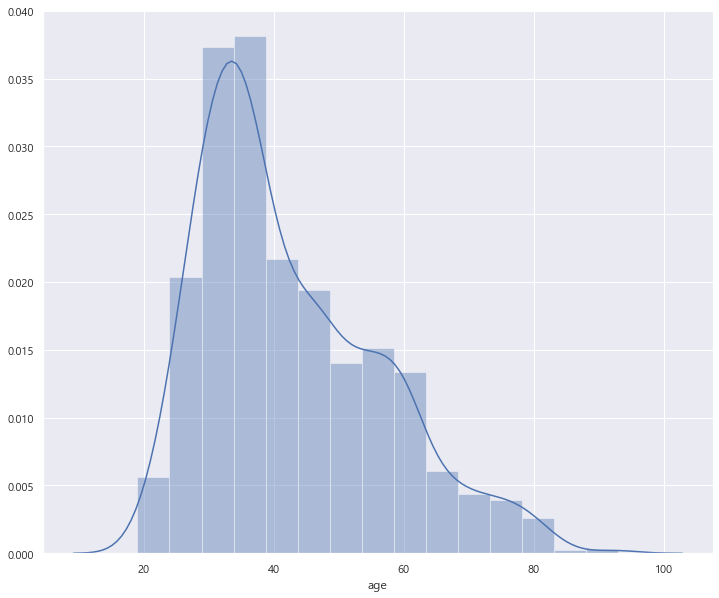

In [106]:
# 2.1. 마케팅 대상
## 2.1.4. deposit 들은 사람들의 연령대 분포

deposit_true = df['deposit'] == 1
sns.distplot(df.loc[deposit_true]['age'], bins=15)

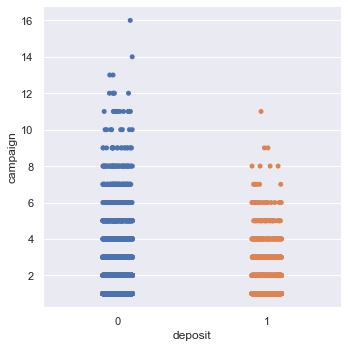

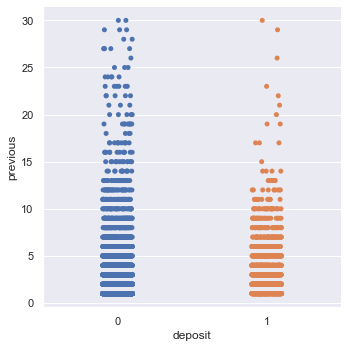

In [107]:
# 2.1. 마케팅 대상
## 2.1.5. 이전 캠페인 동안 연락 횟수(campaign)에 따른 성사 비율

### 캠페인 진행 중 연락 횟수에 따른 deposit 가입 비율
sns.set(rc = {'figure.figsize':(12,10)})
print(sns.catplot(data = df, x = 'deposit', y = 'campaign'))

### 캠페인 진행 이전 연락 횟수에 따른 deposit 가입 비율
sns.set(rc = {'figure.figsize':(12,10)})
print(sns.catplot(data = df, x = 'deposit', y = 'previous'))

(126.0, 189.0, 321.0, 218.66623477584866)

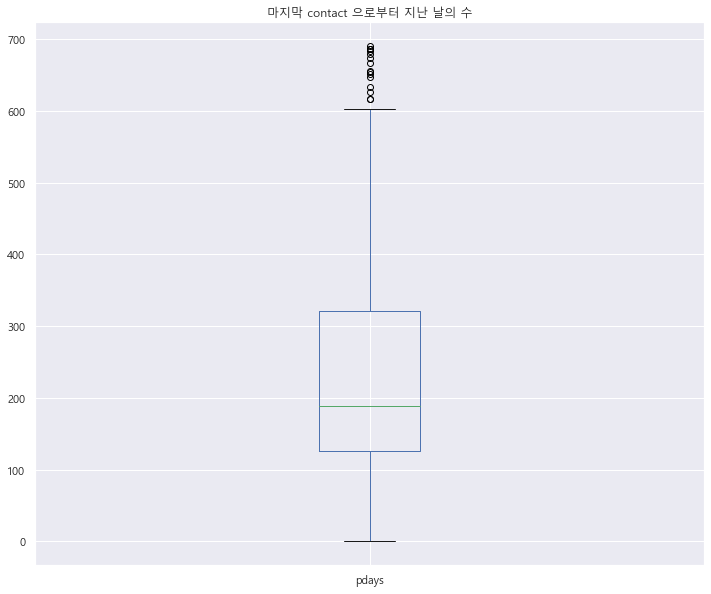

In [108]:
# 2.2. 마케팅 시기
## 2.2.1. pdays 분포: 마지막 contact 후 어느 정도 시간이 지났을 때 홍보하는 게 효과가 좋을까?

plt.rcParams['font.family'] = 'Malgun Gothic'
pdays = plt.subplots(figsize=(12, 10))
pdays = df['pdays'].plot(kind='box')
pdays.set_title("마지막 contact 으로부터 지난 날의 수")

df['pdays'].quantile(0.25), df['pdays'].quantile(0.5), df['pdays'].quantile(0.75), df['pdays'].mean()

apr    0.173709
aug    0.437380
dec    0.495652
feb    0.203252
jan    0.131868
jul    0.544715
jun    0.471698
mar    0.526316
may    0.126288
nov    0.145833
oct    0.495522
sep    0.543919
Name: month, dtype: float64


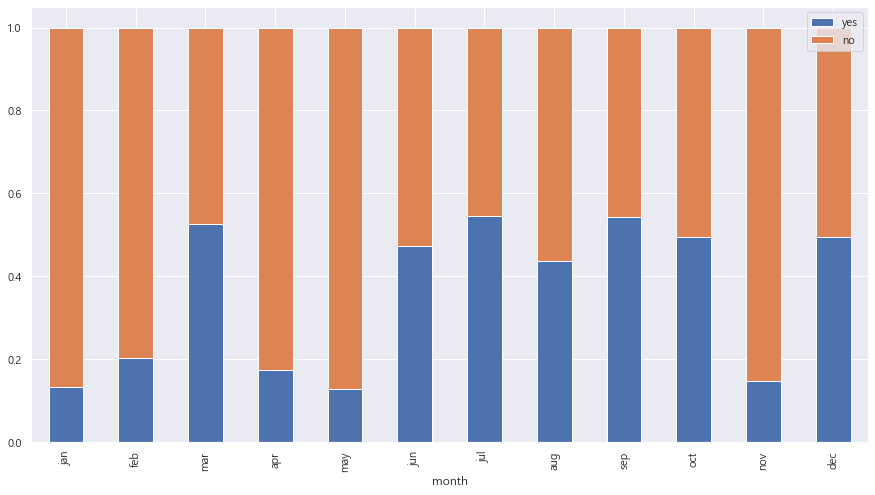

In [109]:
# 2.2. 마케팅 시기
## 2.2.2. month에 따른 deposit 성사 비율: 어느 달에 가장 마케팅 성사율이 높을까?

yes = (df.loc[df['deposit']==1, 'month'].value_counts()/df['month'].value_counts())
print(yes)

month = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
y, n = [], []
for i in month:
    y.append(yes[i])
    n.append(1-yes[i])

dic = {'month':month, 'yes':y, 'no':n}
ratio = pd.DataFrame(dic)
ratio.set_index('month').plot(kind ='bar', stacked = True)
fig = plt.gcf(); fig.set_size_inches(15,8)

            age   job  marital  education  default  housing  balance  loan  \
contact                                                                      
cellular   7057  7057     7057       7057     7057     7057     7057  7057   
telephone   606   606      606        606      606      606      606   606   
unknown      55    55       55         55       55       55       55    55   

            day  month  duration  campaign  pdays  previous  deposit  
contact                                                               
cellular   7057   7057      7057      7057   7057      7057     7057  
telephone   606    606       606       606    606       606      606  
unknown      55     55        55        55     55        55       55  


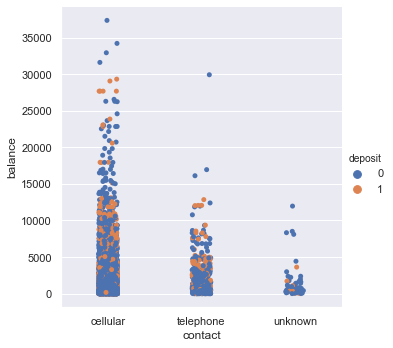

In [110]:
# 2.3. 마케팅 방법
## 2.3.1. contact 수단 분석: 어떤 수단으로 마케팅하는 게 효과가 좋을까?

# 전체적인 연락 유형 분포 살펴보기
sns.set(rc = {'figure.figsize':(12,10)})
print(sns.catplot(data=df, x='contact', y='balance', hue='deposit'))

cont=df.groupby('contact')
print(cont.count())

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


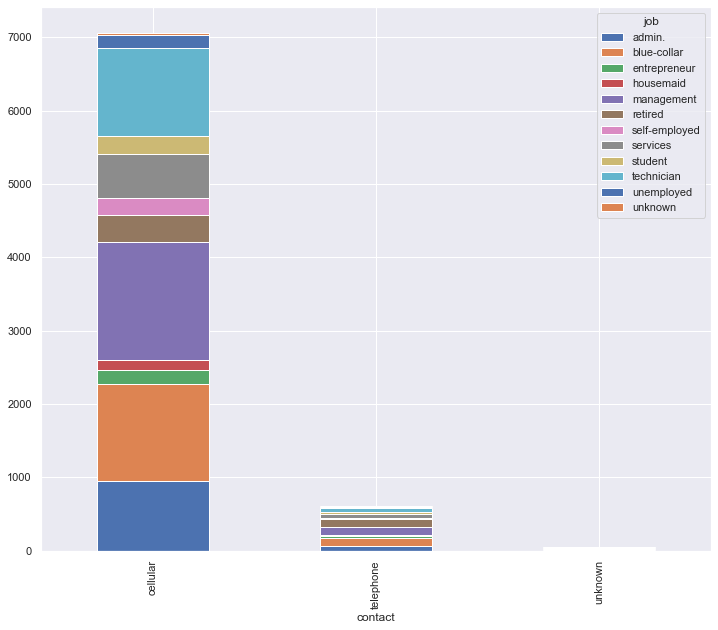

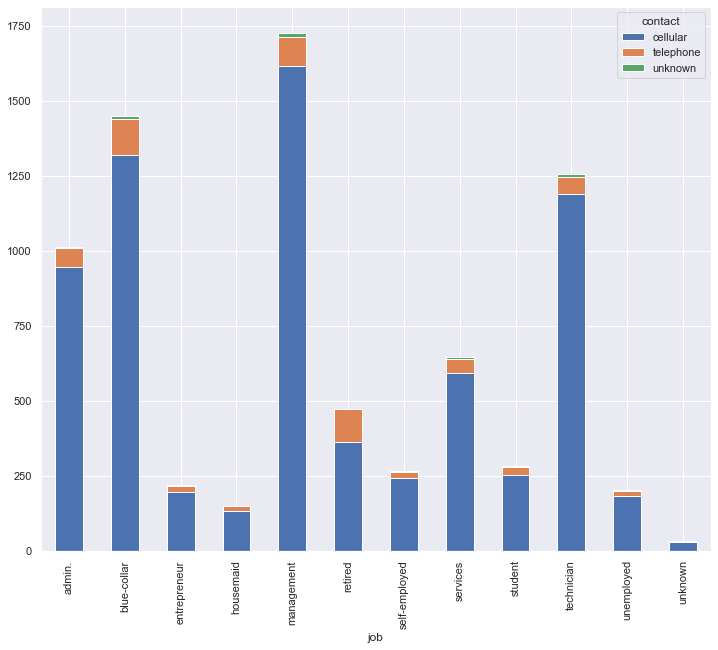

In [111]:
# 직업별 연락형태 비중 보기
conj=pd.crosstab(index=df['contact'], columns=df['job'])
print(conj.plot(kind='bar',stacked=True))

jcon=pd.crosstab(columns=df['contact'], index=df['job'])
print(jcon.plot(kind='bar',stacked=True))

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


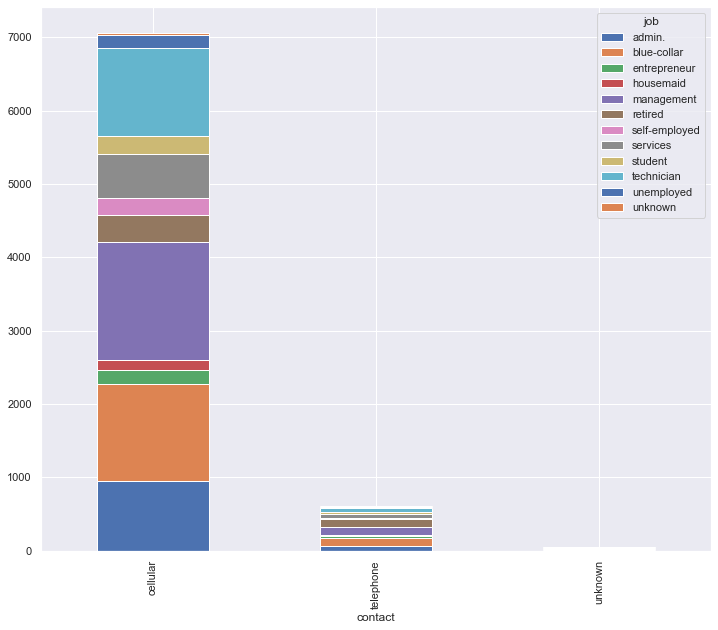

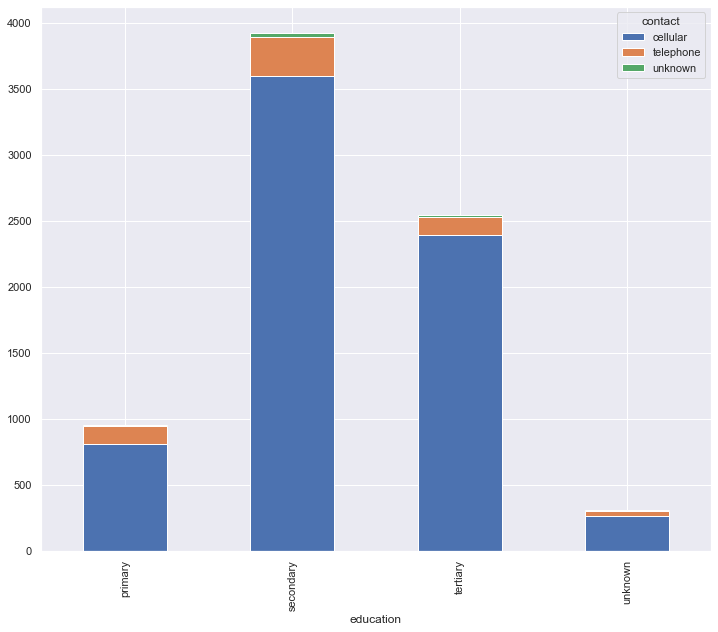

In [112]:
# 교육수준별 연락형태 비중 보기
conedu=pd.crosstab(index=df['contact'], columns=df['education'])
print(conj.plot(kind='bar',stacked=True))

educont=pd.crosstab(index=df['education'], columns=df['contact'])
print(educont.plot(kind='bar',stacked=True))

In [113]:
# contact와 deposit 간의 연관성 : contingency table
print(df['contact'].value_counts())

contdepo=pd.crosstab(index=df['contact'], columns=df['deposit'],margins=True)
print(contdepo)

contdepo['suc']=[1702/7057,135/606,11/55,0]
print(contdepo)

cellular     7057
telephone     606
unknown        55
Name: contact, dtype: int64
deposit       0     1   All
contact                    
cellular   5355  1702  7057
telephone   471   135   606
unknown      44    11    55
All        5870  1848  7718
deposit       0     1   All       suc
contact                              
cellular   5355  1702  7057  0.241179
telephone   471   135   606  0.222772
unknown      44    11    55  0.200000
All        5870  1848  7718  0.000000


<AxesSubplot:title={'center':"customer's age and duration"}, xlabel='age', ylabel='duration'>

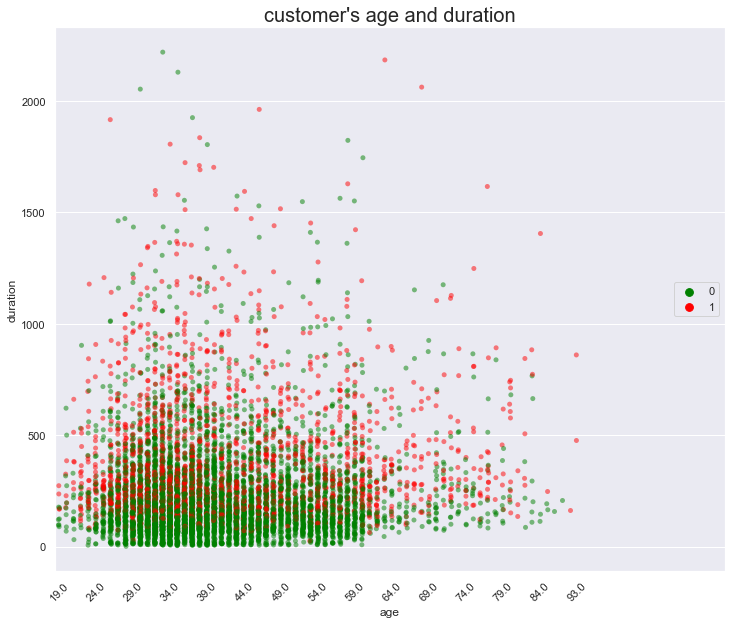

In [114]:
# 2.3. 마케팅 방법
## 2.3.2. duration 분석: contact 지속 시간은 어느 정도로 잡고 홍보 전략을 짜야 할까?

# 나이에 따른 duration 분포 (hue='deposit')
import numpy as np

sns.set(rc = {'figure.figsize':(12,10)})
age_duration = sns.stripplot(x='age', y='duration', hue="deposit", palette=["green", "red"], data=df, alpha=0.5)
plt.title("customer's age and duration", size=20)
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 95, 5))
plt.yticks(np.arange(0, 2500, 500))
plt.legend(loc='center right')
age_duration

No handles with labels found to put in legend.


AxesSubplot(0.125,0.125;0.775x0.755)


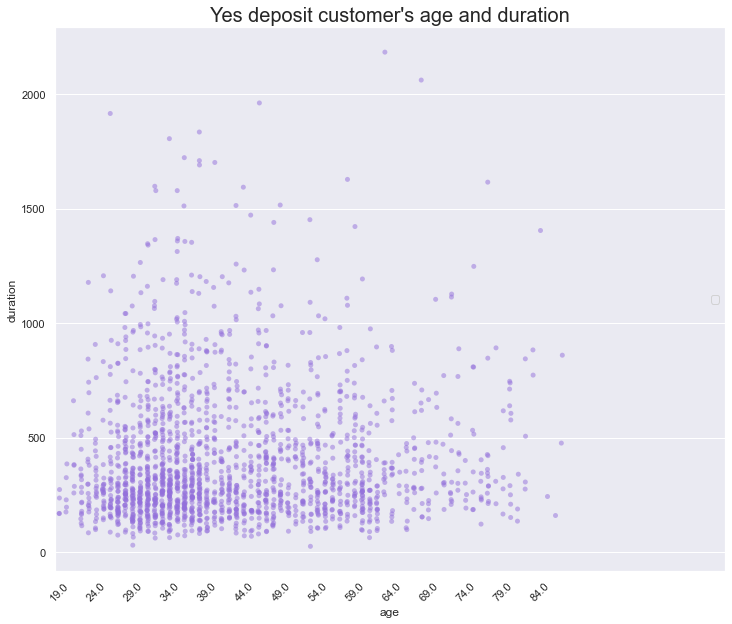

In [115]:
# deposit yes인 사람들의 duraiton 분포

sns.set(rc = {'figure.figsize':(12,10)})
yes_age_duration = sns.stripplot(x='age', y='duration',palette=["mediumpurple"], data=df.loc[df['deposit']==1], alpha=0.5)
plt.title("Yes deposit customer's age and duration", size=20)
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 95, 5))
plt.yticks(np.arange(0, 2500, 500))
plt.legend(loc='center right')
print(yes_age_duration)

No handles with labels found to put in legend.


AxesSubplot(0.125,0.125;0.775x0.755)


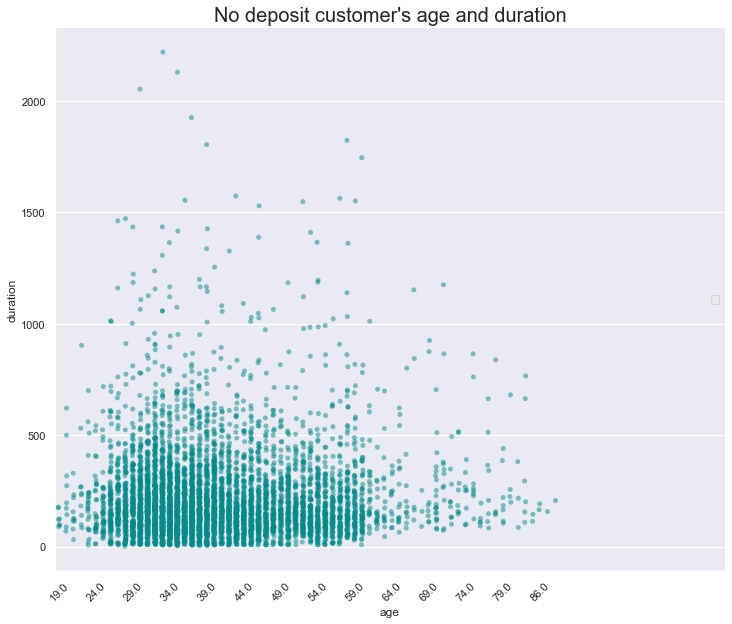

In [116]:
# deposit no인 사람들의 duraiton 분포

sns.set(rc = {'figure.figsize':(12,10)})
no_age_duration = sns.stripplot(x='age', y='duration',palette=["darkcyan"], data=df.loc[df['deposit']==0], alpha=0.5)
plt.title("No deposit customer's age and duration", size=20)
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 95, 5))
plt.yticks(np.arange(0, 2500, 500))
plt.legend(loc='center right')
print(no_age_duration)